In [2]:
import mujoco
import mediapy as media
import casadi
import numpy as np

In [3]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

with open("hopper.xml", "r") as xml_file:
  xml = xml_file.read()

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)


# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
data.ctrl = [1,1,1]
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)
      # print(data.qpos)

media.show_video(frames, fps=framerate)
# media.show_image(frames[0])
# print(frames[0])

In [16]:
data = mujoco.MjData(model)
# print(2*model.nv+model.na)
mujoco.mj_kinematics(model, data)
print('raw access:\n', data.qpos)
A, B, C, D = np.ndarray((12,12), dtype=np.float64), np.ndarray((12,3), dtype=np.float64), np.ndarray((0,12), dtype=np.float64), np.ndarray((0,3), dtype=np.float64)
# print(C.shape)
mujoco.mjd_transitionFD(model, data, np.float64(0.001), np.int64(1), A, B, C, D)
print(A, B, C, D)

# mujoco.mj_resetData(model, data)
# fd = mujoco.mj_forward(model, data)
# print(fd)

# MjData also supports named access:
# print('\nnamed access:\n', data.geom('').qpos)

raw access:
 [0.   1.25 0.   0.   0.   0.  ]
[[ 1.00000000e+00  0.00000000e+00 -8.90985619e-20 -1.14383454e-04
  -2.05781134e-04 -9.03332507e-21  1.99999857e-03 -3.76968456e-20
  -4.36716960e-16 -3.14068243e-06 -5.56138030e-06 -3.04212282e-08]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  5.76917358e-06
   2.43244186e-05  0.00000000e+00  1.54098956e-10  2.00000000e-03
   0.00000000e+00  1.58053348e-07  6.47696119e-07  3.70170561e-08]
 [ 2.00900990e-19  0.00000000e+00  1.00000000e+00 -1.92172017e-03
  -9.63941693e-04  3.81438719e-19 -8.98087354e-09  3.90401487e-20
   2.00000000e-03 -5.19592899e-05 -2.65465561e-05 -7.87285189e-09]
 [ 2.29704896e-19  0.00000000e+00  6.55688920e-19  9.97660770e-01
   1.42982073e-04  4.32042857e-19 -3.00595324e-09  1.31346443e-19
   3.59878317e-18  1.93717996e-03  3.00522435e-06  1.76316801e-08]
 [-2.22230246e-19  0.00000000e+00 -5.95221781e-21  1.31289803e-04
   9.97660767e-01  6.02920666e-19 -1.38680954e-08 -1.67049541e-19
   7.89815768e-18  2.767704

In [186]:
class MyCallback(casadi.Callback):
  def __init__(self, name, d, opts={}):
    casadi.Callback.__init__(self)
    self.d = d
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 6

  # Initialize the object
  def init(self):
    print('initializing object')

    xml = open("hopper.xml", 'r').read()
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    self.model = model
    self.data = data
    mujoco.mj_resetData(model, data)
    self.renderer = mujoco.Renderer(self.model)
    self.scene_option = mujoco.MjvOption()
    self.scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

  # Evaluate numerically
  def eval(self, arg):
    mujoco.mj_step(self.model, self.data)
    self.renderer.update_scene(self.data, scene_option=self.scene_option)
    pixels = self.renderer.render()
    media.show_image(pixels)
    # print(pixels)
    qpos = self.data.qpos
    # print(self.data.ctrl)
    return qpos

initializing object


""

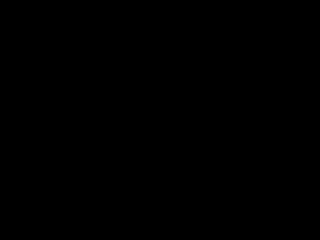

(DM(1.35422e-22), DM(1.24998), DM(1.20943e-21), DM(9.99343e-22), DM(1.30771e-21), DM(1.50718e-21))
(MX(f(x){0}), MX(f(x){1}), MX(f(x){2}), MX(f(x){3}), MX(f(x){4}), MX(f(x){5}))


In [187]:
# Use the function
f = MyCallback('f', 0.5)
print(f(2))

x = casadi.MX.sym("x")
print(f(x))

""

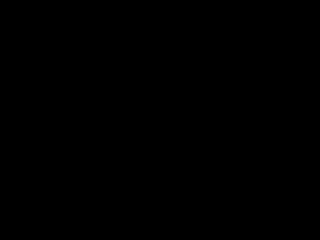

(DM(-0.000532828), DM(1.19897), DM(-0.000299569), DM(1.5995e-05), DM(6.03537e-05), DM(0.00362976))


In [243]:
print(f(0))